# Application of QML to the sine funcion

# 1.Introduction


In this project a variational quantum circuit is used to learn a one-dimensional function
In this case it is the sine function

The variational circuit used is the continuous-variable quantum neural network model described in Killoran et al. (2018) (Quantum machine learning in feature Hilbert spaces, arXiv:1803.07128 [quant-ph]).


# 2. Installs, Imports

We import PennyLane, the wrapped version of NumPy provided by PennyLane, and an optimizer.

In [1]:
pip install -q pennylane


[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer

import matplotlib.pyplot as plt

# 3. Target function: sine(x)

The sine function represents the target to be learned by the variational circuit.
The x values are expressed in units of π, i.e. the x values are in the interval [-1,1].
The y values are expressed as sine(π * x).

In [9]:
# Generate sine wave data
limit = 1
x_val = np.linspace(-limit, limit, 50)
y_val = np.sin(x_val * np.pi)  # Generate sine values

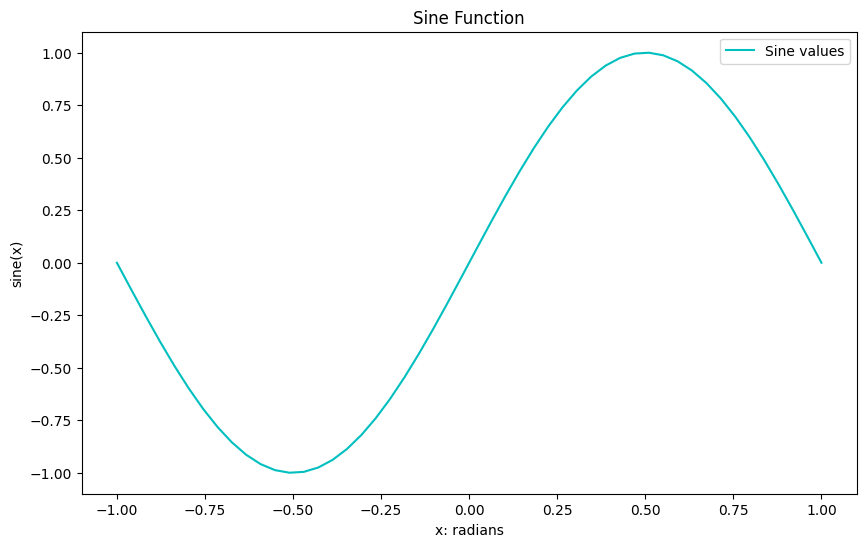

In [10]:

# Plot the shape of the function that the quantum neural network has “learned” from the function and the predicted values
plt.figure(figsize=(10, 6))
plt.plot(x_val, y_val, color="c",label="Sine values")
plt.xlabel("x: radians")
plt.ylabel("sine(x)")
plt.legend()
plt.title("Sine Function")
plt.show()

# 4. Designing the quantum circuit

The device we use is the Strawberry Fields simulator, this time with only one quantum mode (or wire). 

The variational circuit we use is the continuous-variable quantum neural network model described in Killoran et al. (2018). (	arXiv:1803.07128 [quant-ph])

In [13]:

# Define the device to run the program
dev = qml.device("strawberryfields.fock", wires=1, cutoff_dim=10)

For a single quantum mode, each layer of the variational circuit is defined as:

In [14]:
# Define the quantum node
def layer(v):
    # Matrix multiplication of inputs
    qml.Rotation(v[0], wires=0)
    qml.Squeezing(v[1], 0.0, wires=0)
    qml.Rotation(v[2], wires=0)

    # Bias
    qml.Displacement(v[3], 0.0, wires=0)

    # Nonlinear transformation
    qml.Kerr(v[4], wires=0)

The variational circuit in the quantum node first encodes the input into the displacement of the mode, and then executes the layers. The output is the expectation of the x-quadrature.

In [16]:
# Create the Quantum Neural Network
@qml.qnode(dev)
def quantum_neural_net(var, x=None):
    # Encode input x into a quantum state
    qml.Displacement(x, 0.0, wires=0)

    # Call layer(v) which will be the subcircuit of the variational circuit of the neural network
    for v in var:
        layer(v)
    
    return qml.expval(qml.X(0))

In [72]:
xx=0
print(qml.draw(quantum_neural_net)(var, xx))

0: ──D(0.00,0.00)──R(0.10)──S(0.05,0.00)──R(0.06)──D(0.09,0.00)──Kerr(0.09)──R(-0.03)──S(0.11,0.00)

───R(0.01)──D(-0.06,0.00)──Kerr(0.02)──R(0.03)──S(0.17,0.00)──R(0.07)──D(-0.04,0.00)──Kerr(0.03)

───R(0.05)──S(0.14,0.00)──R(0.03)──D(-0.01,0.00)──Kerr(-0.03)─┤  <X>


# 5. Cost function

As an objective function we take the square loss between target labels and model predictions.

In [17]:
# Define the Objective Function
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

In the cost function, we compute the outputs from the variational circuit. Function fitting is a regression problem, and we interpret the expectations from the quantum node as predictions (i.e., without applying postprocessing such as thresholding).

In [17]:
def cost(var, features, labels):
    preds = [quantum_neural_net(var, x=x) for x in features]
    sq_loss = square_loss(labels, preds)
    return sq_loss

# 6. Initializing NN parameters/weights

The network’s weights (called var here) are initialized with values sampled from a normal distribution. We use 4 layers; performance has been found to plateau at around 6 layers.

In [18]:
# Define the Neural Network Parameters and Weights
np.random.seed(0)
num_layers = 4
params_init = 0.05 * np.random.randn(num_layers, 5)
print(params_init)

[[ 0.08820262  0.02000786  0.0489369   0.11204466  0.0933779 ]
 [-0.04886389  0.04750442 -0.00756786 -0.00516094  0.02052993]
 [ 0.00720218  0.07271368  0.03805189  0.00608375  0.02219316]
 [ 0.01668372  0.07470395 -0.01025791  0.01565339 -0.04270479]]


# 7.1 Optimization 1

Using the Adam optimizer, the weights are updated until the convergence criterion is reached.


In [19]:
# Update the Weights Using Optimizer
opt = AdamOptimizer(0.01, beta1=0.9, beta2=0.999)

params = params_init

cost_prev = np.inf
cost_diff = np.inf
costs = []
iterations = []
max_iterations = 500
iteration = 0

convergence_criterion = 1e-3

# Optimization with a while loop
while cost_diff > convergence_criterion and iteration < max_iterations:
    params, cost_new = opt.step_and_cost(lambda v: cost(v, x_val, y_val), params)
    costs.append(cost_new)
    iterations.append(iteration)
    cost_diff = np.abs(cost_prev - cost_new)
    cost_prev = cost_new
    iteration += 1  
    print(f"Iteration: {iteration:5d} | Cost: {cost_new:.7f}") 

print("Stopped")

Iteration:     1 | Cost: 0.3846388
Iteration:     2 | Cost: 0.2652125
Iteration:     3 | Cost: 0.1791604
Iteration:     4 | Cost: 0.1447735
Iteration:     5 | Cost: 0.1627245
Iteration:     6 | Cost: 0.1930768
Iteration:     7 | Cost: 0.1997939
Iteration:     8 | Cost: 0.1845344
Iteration:     9 | Cost: 0.1610401
Iteration:    10 | Cost: 0.1407606
Iteration:    11 | Cost: 0.1292684
Iteration:    12 | Cost: 0.1263910
Iteration:    13 | Cost: 0.1283164
Iteration:    14 | Cost: 0.1304085
Iteration:    15 | Cost: 0.1292670
Iteration:    16 | Cost: 0.1235657
Iteration:    17 | Cost: 0.1140825
Iteration:    18 | Cost: 0.1032037
Iteration:    19 | Cost: 0.0938730
Iteration:    20 | Cost: 0.0881335
Iteration:    21 | Cost: 0.0859525
Iteration:    22 | Cost: 0.0852812
Stopped


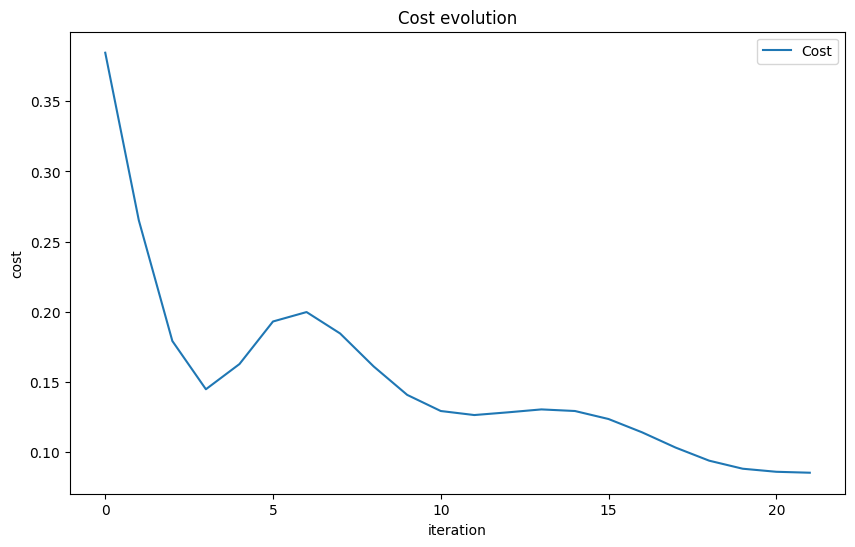

In [23]:

# Plot the shape of the function that the quantum neural network 
# has “learned” from the function and the predicted values
plt.figure(figsize=(10, 6))
plt.plot(iterations, costs, label="Cost")
plt.xlabel("iteration")
plt.ylabel("cost")
plt.legend()
plt.title("Cost evolution")
plt.show()

## Generating predictions

Finally, we collect the predictions of the trained model for 50 values in the range [-1,1]

In [24]:
# Output and Process the Predictions of the Quantum Neural Network
y_pred = [quantum_neural_net(params, x) for x in x_val]
x_pred = x_val

## Compare predicted values with sine(x)
We plot the shape of the function that the model has “learned” 

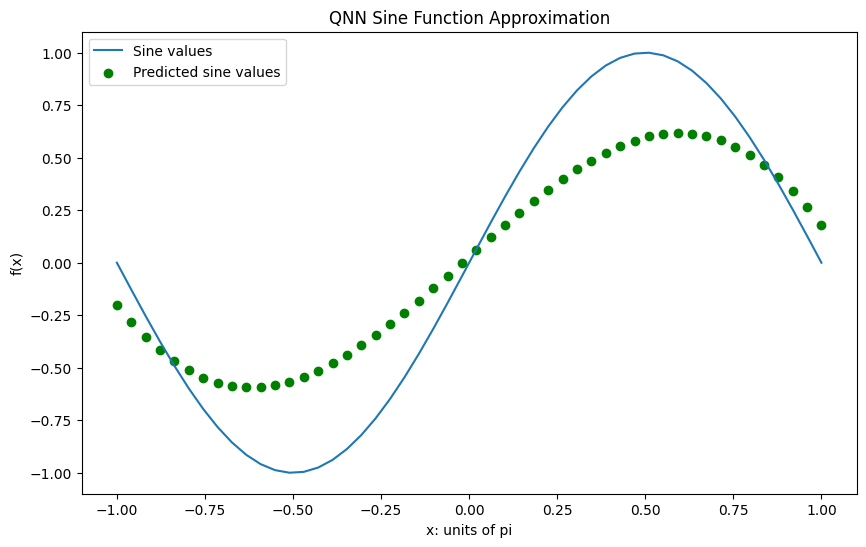

In [24]:
# Plot the shape of the function that the quantum neural network has “learned” from the function and the predicted values
plt.figure(figsize=(10, 6))
plt.plot(x_val, y_val, label="Sine values")
plt.scatter(x_pred, y_pred, color="green", label="Predicted sine values")
plt.xlabel("x: units of pi")
plt.ylabel("f(x)")
plt.legend()
plt.title("QNN Sine Function Approximation")
plt.show()

# 7.2 Optimization 2

In [25]:
# Define the Neural Network Parameters and Weights
np.random.seed(0)
num_layers = 4
params_init = 0.05 * np.random.randn(num_layers, 5)
print(params_init)

[[ 0.08820262  0.02000786  0.0489369   0.11204466  0.0933779 ]
 [-0.04886389  0.04750442 -0.00756786 -0.00516094  0.02052993]
 [ 0.00720218  0.07271368  0.03805189  0.00608375  0.02219316]
 [ 0.01668372  0.07470395 -0.01025791  0.01565339 -0.04270479]]


In [28]:
# Update the Weights Using Optimizer
opt = AdamOptimizer(0.01, beta1=0.9, beta2=0.999)

params = params_init

cost_prev = np.inf
cost_diff = np.inf
costs = []
iterations = []
max_iterations = 1000
iteration = 0

convergence_criterion = 1e-4

# Optimization with a while loop
while (cost_diff >= convergence_criterion) and (iteration < max_iterations):
    params, cost_new = opt.step_and_cost(lambda v: cost(v, x_val, y_val), params)
    costs.append(cost_new)
    iterations.append(iteration)
    cost_diff = np.abs(cost_prev - cost_new)
    cost_prev = cost_new
    #iteration += 1 
    if iteration % 10 ==0:
        print(f"Iteration: {iteration:5d} | Cost: {cost_new:.7f}") 
    iteration += 1

print(f"Stopped at Iteration: ´{iteration:5d} | Cost: {cost_new:.7f}")

Iteration:     0 | Cost: 0.3846388
Iteration:    10 | Cost: 0.1292684
Iteration:    20 | Cost: 0.0859525
Iteration:    30 | Cost: 0.0524923
Iteration:    40 | Cost: 0.0297640
Iteration:    50 | Cost: 0.0184491
Iteration:    60 | Cost: 0.0107363
Iteration:    70 | Cost: 0.0055917
Iteration:    80 | Cost: 0.0027558
Stopped at Iteration: ´   89 | Cost: 0.0016670


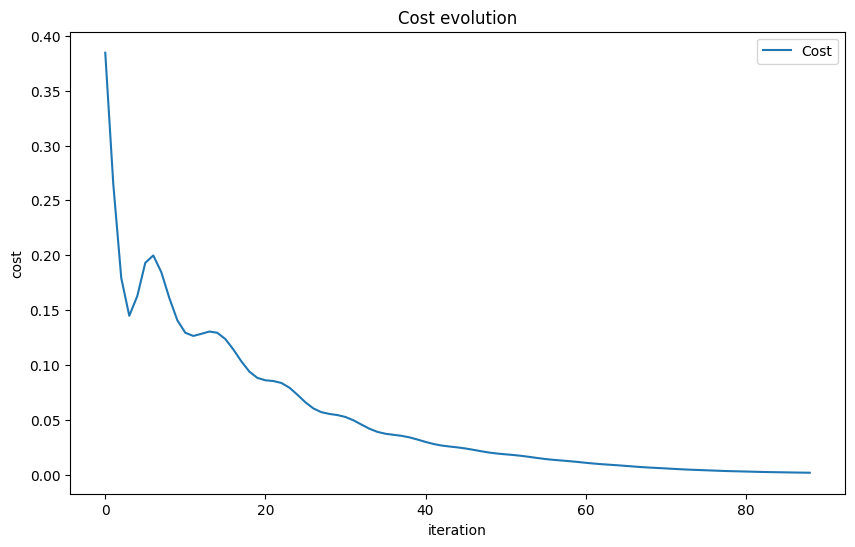

In [30]:
# Output and Process the Predictions of the Quantum Neural Network

# Plot the shape of the function that the quantum neural network has “learned” from the function and the predicted values
plt.figure(figsize=(10, 6))
plt.plot(iterations, costs, label="Cost")
plt.xlabel("iteration")
plt.ylabel("cost")
plt.legend()
plt.title("Cost evolution")
plt.show()

## Generating predictions

- Using the optimized parameters of the quantum circuit, sine values are predicted and compared (graphically) with our target sine function.
- As expected, the smaller the convergence criterion (i.e. the more iterations used in determining the circuit parameters) the better is the fit.


In [29]:
# Output and Process the Predictions of the Quantum Neural Network
y_pred = [quantum_neural_net(params, x) for x in x_val]
x_pred = x_val

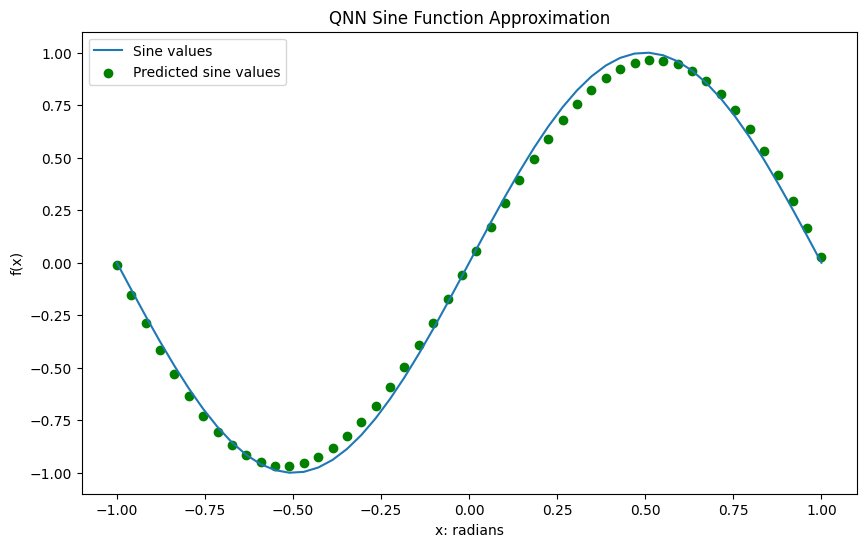

In [29]:
# Plot the shape of the function that the quantum neural network has “learned” from the function and the predicted values
plt.figure(figsize=(10, 6))
plt.plot(x_val, y_val, label="Sine values")
plt.scatter(x_pred, y_pred, color="green", label="Predicted sine values")
plt.xlabel("x: radians")
plt.ylabel("f(x)")
plt.legend()
plt.title("QNN Sine Function Approximation")
plt.show()